# DMT
Mazeworld with discrete morse theory

In [1]:
import sys

sys.path.append("../src")

from environments import MazeEnv
from policies import BaseAgent, QLearningAgent
from dmt import environment_to_graph, classify_simplices, visualize_graph

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [2]:
env = MazeEnv()
agent = BaseAgent(env, gamma=1)
agent.value_iteration()
optimal_value_function = agent.value_function

In [3]:
env = MazeEnv()
agent = QLearningAgent(env, gamma=1, alpha=0.1)
agent.compute_optimal_q_function()
optimal_q_function = agent.q_table

Optimal Q-function computed.


In [4]:
# check if max_a q_{opt}(s, a) == v_{opt{(s)
np.all(np.max(agent.q_table, axis=-1) == optimal_value_function)

True

# Env to graph

In [5]:
G = environment_to_graph(env, optimal_q_function)

In [6]:
list(G.nodes(data=True))[:5]

[(0, {'node_value': -21.998832000000004}),
 (1, {'node_value': -19.9989}),
 (2, {'node_value': -18.998995}),
 (3, {'node_value': -17.998997}),
 (4, {'node_value': -1.999991})]

In [7]:
list(G.edges(data=True))[:5]

[(0, 10, {'edge_value': -21.998832000000004}),
 (1, 11, {'edge_value': -19.9989}),
 (1, 2, {'edge_value': -19.998994}),
 (2, 3, {'edge_value': -18.998995}),
 (3, 12, {'edge_value': -17.998997})]

In [8]:
# Run the classification function
critical_nodes, regular_nodes, critical_edges, regular_edges = classify_simplices(G)

# Check if it's a discrete Morse function and print the results
if critical_nodes is not None:
    print("Discrete Morse function found")
    print("Critical Nodes:", critical_nodes)
    print("Regular Nodes:", regular_nodes)
    print("Critical Edges:", critical_edges)
    print("Regular Edges:", regular_edges)
else:
    print("Not a discrete Morse function")

Discrete Morse function found
Critical Nodes: [6, 86]
Regular Nodes: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85]
Critical Edges: [(1, 2, {'edge_value': -19.998994}), (15, 23, {'edge_value': -4.999938}), (29, 35, {'edge_value': -6.999836}), (42, 43, {'edge_value': -6.999778000000001}), (48, 55, {'edge_value': -8.999756}), (49, 56, {'edge_value': -6.999758000000001}), (58, 64, {'edge_value': -20.998694000000004})]
Regular Edges: [(0, 10, {'edge_value': -21.998832000000004}), (1, 11, {'edge_value': -19.9989}), (2, 3, {'edge_value': -18.998995}), (3, 12, {'edge_value': -17.998997}), (4, 13, {'edge_value': -2.999978}), (4, 5, {'edge_value': -1.999991}), (5, 6, {'edge_value': -0.999995}), (6, 7, {'edge_value'

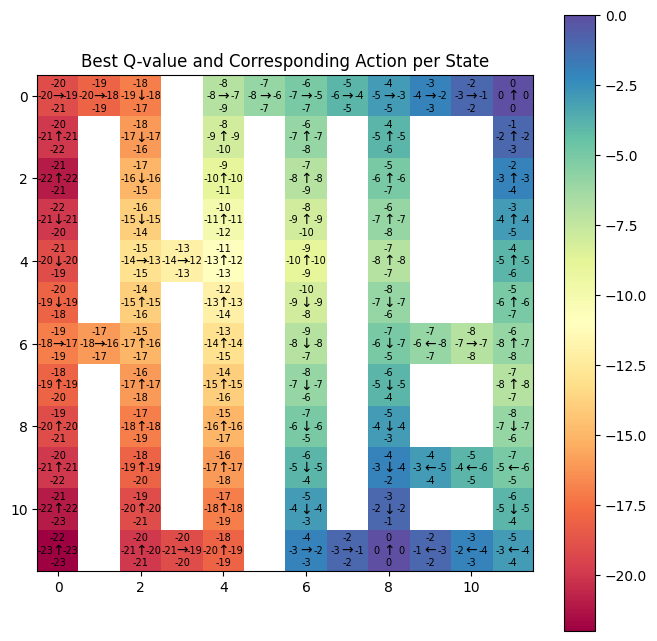

In [9]:
agent.plot_best_action_q_values()

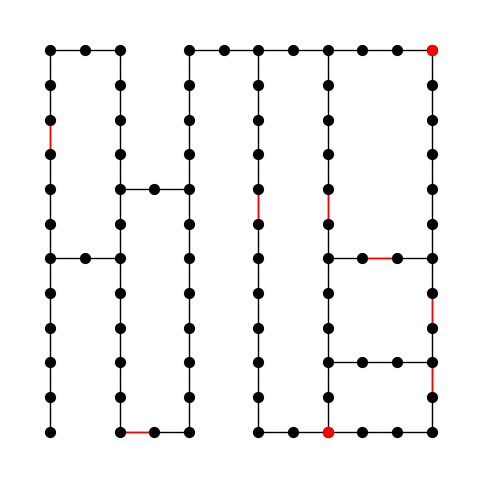

In [10]:
visualize_graph(G, env, critical_nodes, critical_edges)

In [11]:
from dmt import get_induced_gradient_vector_field, visualize_induced_vector_field

V = get_induced_gradient_vector_field(G)

In [12]:
G.has_edge(0, 10)

True

In [13]:
for v, e in V:
    if v in G and e in G:
        print(v, e)

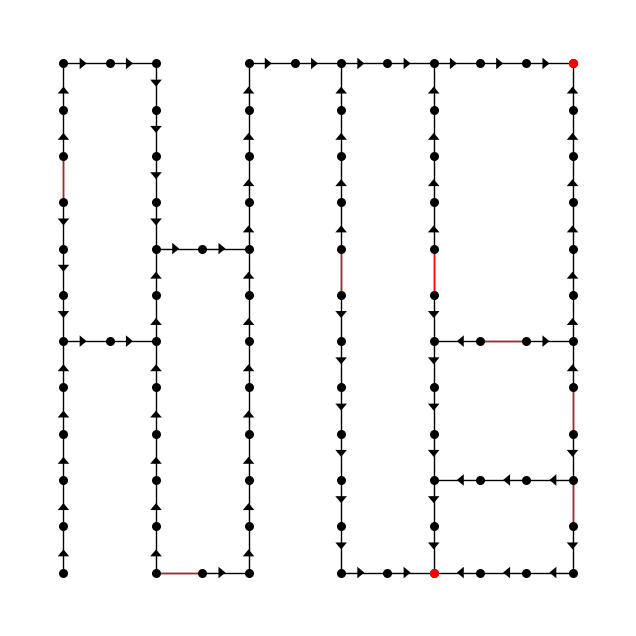

In [14]:
visualize_induced_vector_field(G, env, critical_nodes, critical_edges, V)

In [15]:
G